In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.executable
import torch
import torchvision
torch.__version__, torchvision.__version__
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

In [2]:
meta_params = {}
for model_version in ['0122_swin_baseFlipRotate']:#, '0110_yolov5l_fold0_new_hyp_remove_noaug']:
    model_folder = Path(f"../output/{model_version}/")
    try:
        params_path = model_folder / "config" / "params.pkl"
        params = pickle.load(open(params_path, 'rb'))
    except:
        params_path = model_folder / "config" / "params.yaml"
        params = util.load_yaml(params_path)
    meta_params[model_version] = params

In [3]:
for model_version, params in meta_params.items():
    for key, val in params.items():
        if "dir" in key or "path" in key or "file" in key:
            params[key] = Path(val)
    meta_params[model_version] = params

In [5]:
from mmdet.apis import init_detector, inference_detector
USE_SAHI = False
from glob import glob

for params in meta_params.values():
    if params['tools'] == "yolov5":
        params["repo"] = Path("../yolov5/").resolve()
    ckp = glob(str(params['output_dir']) + "/" + "best*")[0]
    params['ckpt_path'] = ckp

models = {}
for model_version, params in meta_params.items():
    if USE_SAHI:
        model = Yolov5DetectionModel(
            model_path=str(params['ckpt_path']),
            confidence_threshold=params['conf'],
            image_size = params['img_size'],
            device="cuda:0", # or 'cuda:0'
        )    
    else:
        if params['tools']  == "yolov5":
            model = util.load_model(params)
            device = torch.device("cuda")
            model.to(device)
        elif params['tools'] == "mmdetection":
            model = init_detector(str(params['cfg_dir'] / "config.py"), params['ckpt_path'], device='cuda')
    models[model_version] = model    
    #model = load_special_model()
    #models['special'] = model

load checkpoint from local path: /home/vincent/Kaggle/Kaggle_TGBR/output/0122_swin_baseFlipRotate/best_bbox_mAP_epoch_1.pth


In [6]:
img_norm_cfg = {
    'mean': [123.675, 116.28, 103.53],
    'std': [58.395, 57.12, 57.375],
    'to_rgb': True
}

new_test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=[(2560, 1440), (2560, 1440), (3200, 1800), (3200, 1800)],
        flip=[True,False,True,False],
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

model.cfg.test_pipeline = new_test_pipeline
model.cfg.test_pipeline

[{'type': 'LoadImageFromFile'},
 {'type': 'MultiScaleFlipAug',
  'img_scale': [(2560, 1440), (2560, 1440), (3200, 1800), (3200, 1800)],
  'flip': [True, False, True, False],
  'transforms': [{'type': 'Resize', 'keep_ratio': True},
   {'type': 'RandomFlip'},
   {'type': 'Normalize',
    'mean': [123.675, 116.28, 103.53],
    'std': [58.395, 57.12, 57.375],
    'to_rgb': True},
   {'type': 'Pad', 'size_divisor': 32},
   {'type': 'ImageToTensor', 'keys': ['img']},
   {'type': 'Collect', 'keys': ['img']}]}]

# read pkl

In [7]:
test_result = pickle.load(open(params['output_dir'] / "test_result.pkl", 'rb'))

In [8]:
# Train Data
params_eg = list(meta_params.values())[0]
df = pd.read_csv(params_eg['data_path'] / 'train.csv')
df = df.progress_apply(lambda x: util.get_path(x, params_eg, infer=False), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,real_bbox
0,0,40258,0,0,0-0,[],/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,[]
1,0,40258,1,1,0-1,[],/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,[]


In [9]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
df['has_annotations'] = df['num_bbox'] > 0

  0%|          | 0/23501 [00:00<?, ?it/s]

In [10]:
CV_METHOD = "custom"
if CV_METHOD == "custom":
    folds = pd.read_csv("../input/train_folds_balanced.csv")
    df = pd.merge(df, folds[["video_id","video_frame","fold"]], on=["video_id",'video_frame'])
    df = df.query("fold != -1")

In [11]:
df_oof = df.query("fold == 4").copy()
df_oof.shape

(3568, 13)

In [12]:
df_oof.reset_index(drop=True, inplace=True)
df_oof["pred"] = None
df_oof["conf"] = None

In [13]:
USE_CLACHE = False
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(14, 14))
for idx in tqdm(range(len(df_oof))):
    row = df_oof.loc[idx]
    img_path = row["image_path"]
    img = cv2.imread(str(img_path))
    for model_version, model in models.items():
        USE_CLACHE = meta_params[model_version].get("use_clahe", True)
        img2 = img.copy()
        if USE_CLACHE:
            for i in range(3):
                img2[:, :, i] = clahe.apply((img2[:, :, i]))     
        if meta_params[model_version]["tools"] == "yolov5":
            pred_bbox, confs = util.predict(model, img2, size=SIZE, augment=AUGMENT, use_sahi=USE_SAHI)
        elif meta_params[model_version]["tools"] == "mmdetection":
            result = inference_detector(model, img2)
            pred_bbox = result[0][:,:4]
            pred_bbox[:,2:] = pred_bbox[:,2:] - pred_bbox[:,:2]
            pred_confs = result[0][:,4]
            confs = pred_confs.tolist()
            
        df_oof.at[idx, 'pred'] = pred_bbox.tolist()
        df_oof.at[idx, 'conf'] = confs

  0%|          | 0/3568 [00:00<?, ?it/s]

/home/vincent/Kaggle/Kaggle_TGBR/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [16]:
gt_bboxs_list = []
for i in range(df_oof.shape[0]):
#     res = test_result[i][0][:,:5]
#     res[:,2:4] = res[:,2:4] - res[:,:2]
#     df_oof.at[i, "pred"] = res[:,:4]
#     df_oof.at[i, "conf"] = res[:,4]
    gt_bboxs = df_oof.at[i, "real_bbox"]
    gt_bboxs_list.append(np.array(gt_bboxs))

In [17]:
conf_ths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,60,65,70,75,80]
#conf_ths = [0.]
iou_ths = np.arange(0.3, 0.85, 0.05)
#model_names = list(models.keys())# + ["wbf"]
pred_col = "pred"
conf_col = "conf"
for conf_th in conf_ths:
    conf_th /= 100    
    prd_bboxs_list = []
    for index in df_oof.index:
        confis = df_oof.loc[index, conf_col]
        bboxes = df_oof.loc[index, pred_col]
        prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis)) if confis[i] >= conf_th]
        prd_bboxs_list.append(np.array(prd_bboxs))
    tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)
    df_oof["tp"], df_oof["fp"], df_oof["fn"] = tps, fps, fns    
    precision = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=0)
    recall = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=100)    
    score = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
    score_only_bbox =  util.f_beta(*df_oof.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
    print(f"conf_th {conf_th:.2f}, {model_version}: f2 {score:.4f}, precision {precision:.2f}, recall {recall:.2f} score only consider those with bbox: {score_only_bbox:.4f}")

conf_th 0.05, 0122_swin_baseFlipRotate: f2 0.1180, precision 0.03, recall 0.71 score only consider those with bbox: 0.3010
conf_th 0.10, 0122_swin_baseFlipRotate: f2 0.2330, precision 0.06, recall 0.67 score only consider those with bbox: 0.4429
conf_th 0.15, 0122_swin_baseFlipRotate: f2 0.3157, precision 0.10, recall 0.64 score only consider those with bbox: 0.5072
conf_th 0.20, 0122_swin_baseFlipRotate: f2 0.3754, precision 0.14, recall 0.62 score only consider those with bbox: 0.5392
conf_th 0.25, 0122_swin_baseFlipRotate: f2 0.4236, precision 0.19, recall 0.61 score only consider those with bbox: 0.5619
conf_th 0.30, 0122_swin_baseFlipRotate: f2 0.4606, precision 0.24, recall 0.60 score only consider those with bbox: 0.5757
conf_th 0.35, 0122_swin_baseFlipRotate: f2 0.4863, precision 0.29, recall 0.59 score only consider those with bbox: 0.5781
conf_th 0.40, 0122_swin_baseFlipRotate: f2 0.5082, precision 0.34, recall 0.58 score only consider those with bbox: 0.5819
conf_th 0.45, 01

0.535 is the best

# Plot

In [72]:
from PIL import Image

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    
def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):       
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    for idx in range(len(bboxes)):  

        bbox  = bboxes[idx]
        cls   = classes[idx]
        cls_id = class_ids[idx]
        color = colors[idx]

        if cls in show_classes:            
            x1 = int(round(bbox[0]))
            y1 = int(round(bbox[1]))
            w  = int(round(bbox[2]))
            h  = int(round(bbox[3]))

            voc_bbox = (x1, y1, x1+w, y1+h)
            plot_one_box(voc_bbox, 
                         image,
                         color = color,
                         label = cls if class_name else str(cls_id),
                         line_thickness = line_thickness)

    return image

def show_img(img, bboxes, colors, bbox_format='yolo', labels=None):
    names  = labels #['starfish']*len(bboxes) if labels is None else ["prediction"] * (len(labels) - sum(labels)) + ["real"] * sum(labels)
    labels = [0]*len(bboxes) if labels is None else labels
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)

    return Image.fromarray(img), img


In [73]:
color_pred = [(0,123,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx):
    row = df.loc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes, bboxes, confis = row["real_bbox"], row["pred"], row["conf"]
    confis = [str(round(conf, 3)) for conf in confis]
    img_p, img_t = show_img(img, 
                      bboxes.tolist() + real_bboxes, 
                      color_pred * len(bboxes) + color_real * len(real_bboxes), 
                      bbox_format='coco', 
                      labels= confis + [""] * len(real_bboxes))
    return img_p, img_t

In [87]:
df_oof.query("num_bbox > 3")

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,real_bbox,num_bbox,has_annotations,fold,pred,conf,tp,fp,fn
1282,0,8399,4558,820,0-4558,"[{'x': 186, 'y': 67, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[186, 67, 50, 43], [124, 81, 56, 40], [462, 1...",4,True,4,"[[128.62413, 83.98081, 50.52629, 34.134026], [...","[0.9817016, 0.6075577, 0.47750184, 0.19097261,...",16,6,28
1283,0,8399,4559,821,0-4559,"[{'x': 185, 'y': 71, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[185, 71, 50, 43], [122, 84, 56, 40], [463, 1...",4,True,4,"[[128.30986, 89.207756, 48.363083, 33.47072], ...","[0.95801497, 0.9087337, 0.44961116, 0.35254088...",16,6,28
1284,0,8399,4560,822,0-4560,"[{'x': 185, 'y': 74, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[185, 74, 50, 43], [120, 88, 56, 40], [463, 1...",4,True,4,"[[126.64709, 91.49264, 48.669014, 35.91131], [...","[0.9778933, 0.824291, 0.29622468, 0.07743355, ...",18,4,26
1285,0,8399,4561,823,0-4561,"[{'x': 184, 'y': 78, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[184, 78, 50, 43], [119, 92, 56, 40], [464, 1...",4,True,4,"[[125.35319, 99.093864, 50.200096, 32.483757],...","[0.97909504, 0.9718473, 0.32405302, 0.22555546...",16,6,28
1286,0,8399,4562,824,0-4562,"[{'x': 182, 'y': 80, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[182, 80, 50, 43], [117, 95, 56, 40], [464, 1...",4,True,4,"[[121.47419, 102.74721, 51.379616, 34.076324],...","[0.98478067, 0.93347543, 0.6252423, 0.45370308...",16,17,28
1287,0,8399,4563,825,0-4563,"[{'x': 179, 'y': 81, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[179, 81, 50, 43], [115, 99, 56, 40], [465, 1...",4,True,4,"[[121.59178, 105.2602, 49.31044, 34.206856], [...","[0.9762645, 0.9305294, 0.420361, 0.2533885, 0....",18,4,26
1288,0,8399,4564,826,0-4564,"[{'x': 177, 'y': 83, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[177, 83, 50, 43], [114, 102, 56, 40], [465, ...",4,True,4,"[[118.7499, 107.2653, 51.161446, 37.886223], [...","[0.982127, 0.96545446, 0.5347848, 0.43137774, ...",17,5,27
1289,0,8399,4565,827,0-4565,"[{'x': 175, 'y': 85, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[175, 85, 50, 43], [112, 106, 56, 40], [466, ...",4,True,4,"[[118.65567, 109.829094, 46.681686, 36.906105]...","[0.9703382, 0.9500177, 0.53842795, 0.40691853,...",16,6,28
1290,0,8399,4566,828,0-4566,"[{'x': 173, 'y': 86, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,"[[173, 86, 50, 43], [110, 109, 56, 40], [467, ...",4,True,4,"[[181.02399, 94.03438, 39.72986, 36.74341], [1...","[0.9664469, 0.94979745, 0.54744434, 0.27984214...",16,6,28
1291,0,8399,4567,829,0-4567,"[{'x': 170, 'y': 88, 'width': 50, 'height': 43...",/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/ten

In [90]:
df_oof.loc[1338]["image_path"]

PosixPath('/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/images/video_0_4614.jpg')

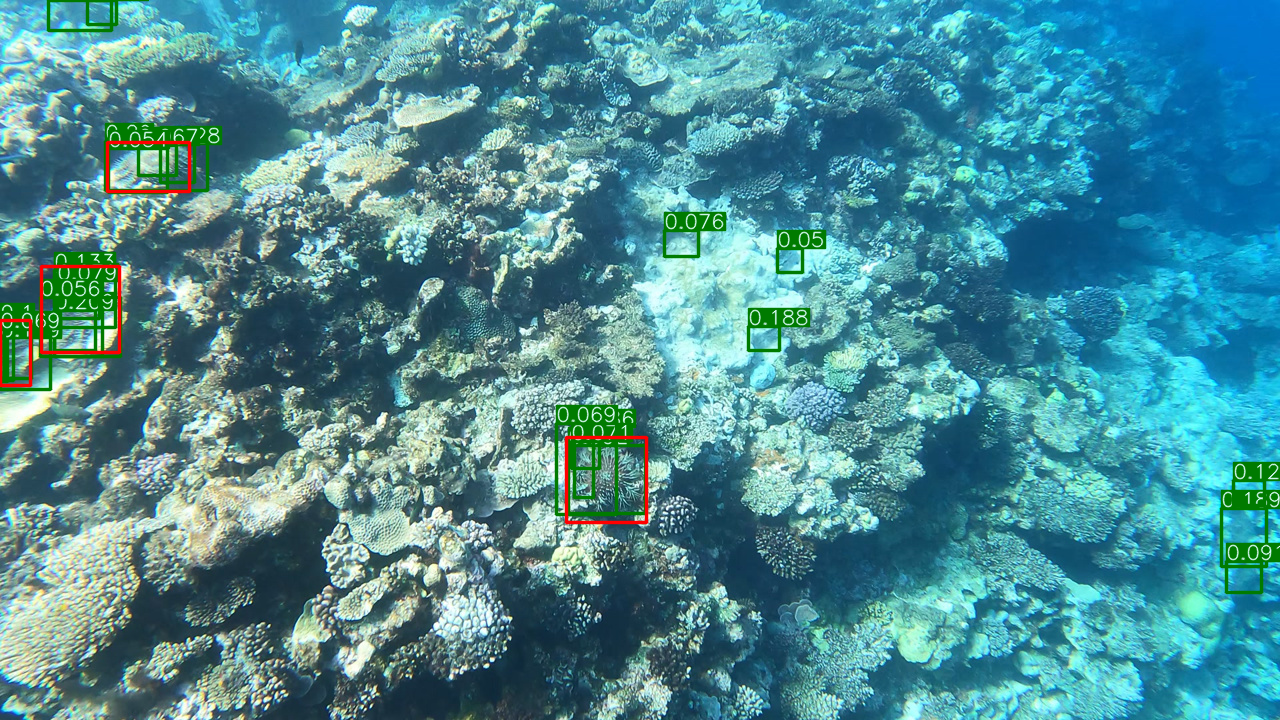

In [89]:
img_p, img_t = plot_img(df_oof,1338)
img_p

In [83]:
for i in tqdm(range(len(df_oof))):
    img_p, img_t = plot_img(df_oof,i)
    img_p.save(str(df_oof["image_path"][i]).replace("images","images_pred"))

  0%|          | 0/3568 [00:00<?, ?it/s]